Notes:
- Labeled training data: 1000 classes, each with 64 images
- Labeled validation data: 1000 classes, each with 64 images
- Unlabeled data: 512000 images
- images missing from /supervised/train/n01540090

# Set Up

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset

In [3]:
# Load labeled training data

train_data = datasets.ImageFolder(
    root='./ssl_data_96/supervised/train/',
    transform=transforms.ToTensor() # transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

In [4]:
# Load labeled validation data

test_data = datasets.ImageFolder(
    root='./ssl_data_96/supervised/val/',
    transform=transforms.ToTensor() # transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

In [ ]:
# Load unlabeled training data

# unsup_data = datasets.ImageFolder(
#     root='./ssl_data_96/unsupervised/',
#     transform=transforms.ToTensor() # transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# )
# unsup_loader = torch.utils.data.DataLoader(
#     unsup_data,
#     batch_size=32,
#     shuffle=True,
#     num_workers=0
# )

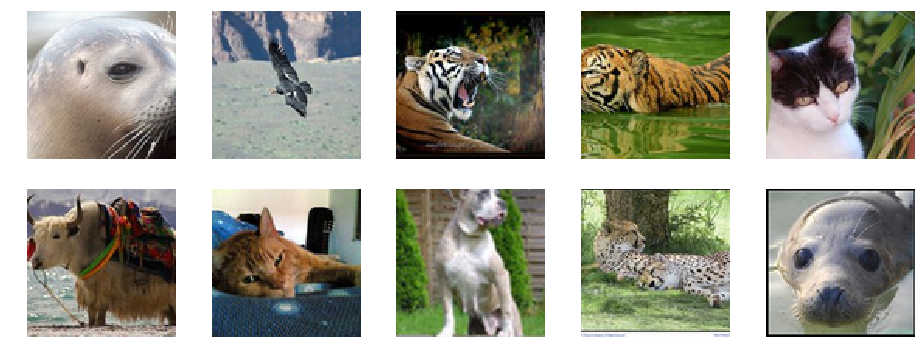

In [5]:
# Show some images

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1) # rows, columns, index
    image, _ = train_loader.dataset.__getitem__(i)
    image = image.permute(1, 2, 0) # change from size 3 x 96 x 96 into 96 x 96 x 3
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# CNN

In [6]:
image_len = 96             # All images are square, length 96
input_size = 96 * 96 * 3   # RBG images of size 96 x 96
n_features = 6             # number of feature maps
num_classes = 1000         # number of classes in labeled data

In [7]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, num_classes):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*21*21, 50)
        self.fc2 = nn.Linear(50, num_classes)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*21*21)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# Train and Test Functions

In [8]:
accuracy_list = []

def train(epoch, model):
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
                
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    
    model.eval()
    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

# Train CNN

In [ ]:
model = CNN(input_size, n_features, num_classes)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1):
    train(epoch, model)
    test(model)

Train Epoch: 0 [0/64000 (0%)]	Loss: 6.890072
